In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
from scipy import  stats
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor as GBR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from numpy.linalg import LinAlgError

D:\Software\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
df_HS300 = pd.read_csv('df_000300.csv', header=0, index_col=0, encoding='utf-8')
df_ZZ500 = pd.read_csv('df_000905.csv', header=0, index_col=0, encoding='utf-8')

In [5]:
% matplotlib inline

In [6]:
def WT(index_list,wavefunc='db4',lv=4,m=1,n=4):   

   
   '''
   index_list: input sequence; 
   
   lv: decomposing level；
 
   wavefunc: 小波函数；
   m,n则选择了进行阈值处理的小波系数层数
   
   '''

    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # 计算阈值
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零b

    # 重构
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
            
    #denoised_index = np.sum(coeff, axis=0)   

    # 在原dataframe中添加处理后的列便于画图
    #data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})

    # 画图
    #data.plot(figsize=(10,10),subplots=(2,1))
    #data.plot(figsize=(10,5))
   
    return coeff

In [7]:
def AR_MA(coeff):
    warnings.filterwarnings('ignore')
    order, model, results = [], [], []

    for i in range(1, len(coeff)):
        order.append(sm.tsa.arma_order_select_ic(coeff[i], ic='aic')['aic_min_order'])
        model.append(ARMA(coeff[i], order=order[i-1]))
    
    for i in range(len(model)):
        new_order = list(order[i])
        while True:
            try:
                results.append(model[i].fit())
                
            except ValueError:
                new_order[1] = np.max((0, new_order[1]-1))
                model[i] = ARMA(coeff[i+1], order=new_order)

            if len(results)>= i+1:
                break                
    
    return results

In [8]:
def NonlinReg(coeff, features=4, interval=0, length=1):
    X, Y = [], []
    for i in range(len(coeff[0])):
        if i+features+interval < len(coeff[0]):
            X.append(coeff[0][i:i+features])
            Y.append(coeff[0][i+features+interval])
    X =  np.array(X)
    Y =  np.array(Y)


    gbr = GBR(learning_rate=0.1, n_estimators=80, max_depth=2).fit(X, Y)

    X_ = copy.deepcopy(X)
    Y_ = copy.deepcopy(Y)
    for i in range(length):
        X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
        Y_ = np.concatenate((Y_, gbr.predict(X_[-1])))
    
    return Y_[-length:]

In [9]:
def ModelEvaluation(index_predict, index_real):    
    model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # 回归评估指标对象集
    model_metrics_list = []  # 回归评估指标列表
    for m in model_metrics_name:  # 循环每个指标对象
        tmp_score = m(index_predict, index_real)  # 计算每个回归指标结果
        model_metrics_list.append(tmp_score)
    df = pd.DataFrame(np.array([model_metrics_list]), index=['model'], columns=['ev', 'mae', 'mse', 'r2'])
    return df

In [12]:
start_day = '2010-01-04'
end_day = '2012-12-31'
test = df_HS300.loc[start_day:end_day,:]
test_C = test['CLOSE'] 
StockDate = df_HS300.loc['2013-01-01':'2013-01-20',:]
test_lag = StockDate['CLOSE']

In [13]:
timelen = 150
length = 1
index_predict, index_real = [], []
for i in range(10):
    test_ = test.iloc[i:i+timelen, :] 
    coeff_O = WT(test_.OPEN)
    coeff_H = WT(test_.HIGH)
    coeff_L = WT(test_.LOW)
    coeff_C = WT(test_.CLOSE)
    
    test_coef0 = pd.DataFrame([coeff_O[0],coeff_H[0],coeff_L[0],coeff_C[0]]).T
    window = 3
    X = pd.rolling_mean(test_coef0, window).dropna().values[:-1,:]
    Y = coeff_C[0][window:]
    gbr = GBR(learning_rate=0.06, n_estimators=50, max_depth=3).fit(X,Y)
    x = pd.rolling_mean(test_coef0, window).dropna().values[-1,:]
    y = gbr.predict(x)
    
    results = AR_MA(coeff_C)
    
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(timelen-1, timelen+length-1, dynamic=True))
    
    index_predict.append(y+np.sum(np.array(D_series)[:,-1], axis = 0))
    index_real.append(test.CLOSE[i+timelen:i+timelen+length].values)    

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  del sys.path[0]
D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  app.launch_new_instance()
D:\Software\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [18]:
index_real = []
for i in range(10):
    index_real.append(test.CLOSE[i+timelen:i+timelen+length].values) 

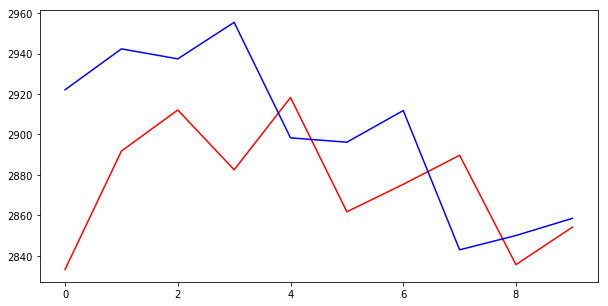

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict, 'red')
plt.plot(index_real, 'blue')